In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision.models.vgg import vgg16, VGG

In [2]:
dtype = torch.float32
USE_GPU = True
device = torch.device('cpu')
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
device

device(type='cuda')

In [3]:
class UniformDataset(Dataset):
    def __init__(self, img_dir = 'dataset_scaled'):
        self.img_dir = img_dir
        class_dirs = os.listdir(self.img_dir)
        self.data = []
        for class_name in class_dirs:
            for img_name in os.listdir(os.path.join(self.img_dir, class_name)):
                self.data.append([os.path.join(self.img_dir, class_name, img_name),
                                  class_name])
        self.class_map = {'nouniform': 0, 'uniform': 1}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = torch.from_numpy(img)
        # (канал, х, у)
        img = img.permute(2, 0, 1)
        class_id = self.class_map[class_name]
        return img, torch.tensor(class_id)

In [6]:
full_dataset = UniformDataset(r'..\uniform_detection\dataset_scaled')

n = len(full_dataset)

test_n = int(0.2*n)
train_n = n - test_n
train_dataset, test_dataset = random_split(full_dataset, (train_n, test_n))
train_dataloader = DataLoader(train_dataset, batch_size = 15)
test_dataloader = DataLoader(test_dataset, batch_size = 15)
print(len(train_dataset), len(test_dataset))

6618 1654


In [10]:
classifier = torchvision.models.vgg16(pretrained=True)

for param in classifier.features.parameters():
    param.requires_grad = False
    
n_inputs = classifier.classifier[6].in_features
classifier.classifier[6] = nn.Linear(n_inputs, 2)
classifier.classifier[6].out_features
classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001)
epoches = 5
hyper_params = (optimizer, criterion, epoches)
type(classifier)

torchvision.models.vgg.VGG

In [4]:
def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = F.softmax(model(x))
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    accuracy = float(num_correct) / num_samples
    return accuracy

In [5]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                test_loader: DataLoader,
                device: torch.device,
                hyper_params: (optim.Optimizer,
                               nn.BCELoss or nn.CrossEntropyLoss,
                               int)):
    optimizer, criterion, epoches = hyper_params
    losses = []
    accuracies = {'train' : [], 'test': []}
    for e in range(epoches):
        total_loss = 0
        model.train()
        for batch, (x, y) in enumerate(train_loader):
            model.train()
            x, y = x.to(device= device, dtype= dtype), y.to(device= device)
            optimizer.zero_grad()
            predictions = model(x)

            loss = criterion(predictions, y)
            total_loss += loss.item()
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(total_loss)
        print(e)
        print(losses[-1])
        accuracies['train'].append(check_accuracy(train_loader, model))
        accuracies['test'].append(check_accuracy(test_loader, model))
        print(accuracies['train'][-1])
        print(accuracies['test'][-1])
    return losses, accuracies

In [13]:
losses, accuracies = train_model(classifier, train_dataloader, test_dataloader, device, hyper_params)

0
371.7824784964323


C:\Users\alexg\AppData\Local\Temp/ipykernel_12380/2415958310.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = F.softmax(model(x))


0.8918102145663342
0.8839177750906893
1
159.26169309020042
0.9108491991538229
0.8972188633615478
2
130.6026605181396
0.9181021456633424
0.8978234582829504
3
114.70191253721714
0.9374433363553943
0.9268440145102781
4
98.39769917377271
0.9395587790873375
0.9207980652962515


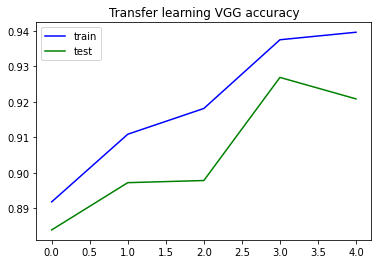

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(epoches), accuracies['train'],'b', label= 'train')
plt.plot(range(epoches), accuracies['test'],'g', label= 'test')
plt.legend()
plt.title('Transfer learning VGG accuracy')
plt.show()

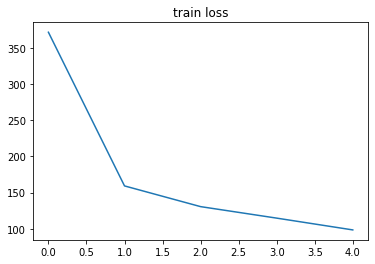

In [17]:
plt.plot(range(epoches), losses)
plt.title('train loss')
plt.show()

# Сохранение модели

In [19]:
PATH = 'model.pth'
torch.save(classifier.state_dict(), PATH)

# Объединение с детектором

In [6]:
detector = torch.hub.load('ultralytics/yolov5', 'yolov5s').to(device)

PATH = 'model.pth'
classifier = vgg16()
classifier.classifier[6] = torch.nn.Linear(4096, 2)
classifier.load_state_dict(torch.load(PATH))
classifier = classifier.to(device)
classifier
classifier.eval()

Using cache found in C:\Users\alexg/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2021-10-14 torch 1.10.0+cu113 CUDA:0 (NVIDIA GeForce RTX 2060, 6143.6875MB)

Fusing layers... 
C:\all_files\uniform_detection\uniform_venv\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
def detect_humen(frame, model):
    results = model(frame).pandas().xyxy[0]
    human_frames = results[results['name'] == 'person'][['xmin', 'ymin', 'xmax', 'ymax']].to_dict()
    return human_frames

def crop_img(img, xmin, xmax, ymin, ymax):
    frame = img[ymin: ymax, xmin: xmax]
    return frame

In [20]:
def image_transforms(base_image: np.array):
    size = (72, 163)
    img = cv2.resize(base_image, size, interpolation= cv2.INTER_AREA)
    img = torch.from_numpy(img)
    img = img.permute(2, 0, 1)
    img = torch.unsqueeze(img, 0)
    return img

def predict_uniform(classifier: VGG, img: np.array, device):
    transformed_img = image_transforms(img).to(device= device, dtype= torch.float32)
    return classifier(transformed_img)

def draw_rectangle(frame, start_point, end_point, class_label, thickness = 2):
    color = (0, 255, 0) if class_label else (0, 0, 255)
    result = cv2.rectangle(frame, start_point, end_point, color, thickness)
    return result  

def test_detector(detector, classifier, device, video_path: str = 'v2.avi', result_path = 'result.mp4'):
    video = cv2.VideoCapture(video_path)
    frame_width, frame_height = int(video.get(3)), int(video.get(4))
    video_writer = cv2.VideoWriter(result_path, cv2.VideoWriter_fourcc('M','J','P','G'),
                                   100, (frame_width, frame_height)) # чет придумать для сокращения занимаемой памяти
    frame_count = -1
    while True:
        success, frame = video.read()
        if not success:
            break
        frame_count += 1
        #зона детекции
        res = detect_humen(frame, detector)
        
        person_labels = {}
        xmin, ymin, xmax, ymax = res['xmin'], res['ymin'], res['xmax'], res['ymax']
        person_keys = res['xmin'].keys()
        #зона классификации
        for key in person_keys:
            cropped_frame = crop_img(frame,
                                     int(xmin[key]), int(xmax[key]),
                                     int(ymin[key]), int(ymax[key]))
            scores = F.softmax(predict_uniform(classifier, cropped_frame, device), dim= 1) # если че, убрать дим, но он деприкейтед
            class_label = scores.max(1)[1].item()
            
            #отрисовка прямоугольников
            start_point = (int(xmin[key]), int(ymin[key]))
            end_point = (int(xmax[key]), int(ymax[key]))
            frame = draw_rectangle(frame, start_point, end_point, class_label)
        
        #сохранение видео
        video_writer.write(frame)
    video_writer.release()

In [21]:
start_time = time.time()
test_detector(detector, classifier, device, video_path='uniform.mp4', result_path='uniform_result.mp4')
end_time = time.time()
end_time - start_time

614.0477180480957

In [22]:
start_time = time.time()
test_detector(detector, classifier, device, video_path='nouniform.mp4', result_path='nouniform_result.mp4')
end_time = time.time()
end_time - start_time

240.97791075706482

# TODO: добавить описание методов
# TODO: сжать итоговое видео
# TODO: 